In [760]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.time import Time

from synthetic_lightcurves import *

project_root = os.path.join(os.getcwd(), 'midir-agn-reverberation', 'src')
sys.path.append(project_root)

from reverberation_mapper import *
import lightcurve_processing as lp
import fileIO_processing as fp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [836]:
t, m = generate_drw()
t = (t*u.day).to(u.year)

Text(0, 0.5, 'magnitude')

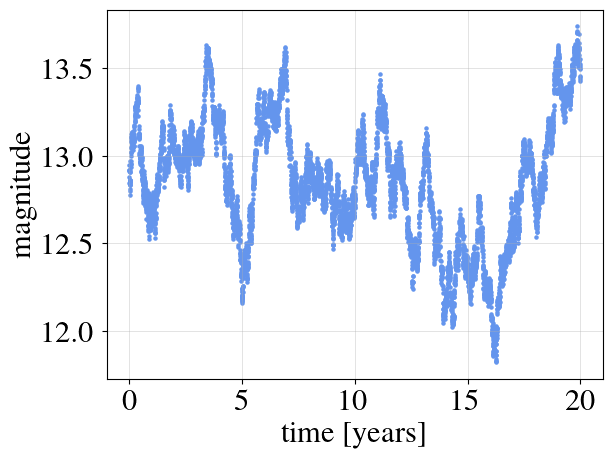

In [837]:
fig, ax = plt.subplots()

ax.scatter(t, m+13, s=5, c='cornflowerblue')
ax.grid(lw=0.5, alpha=0.5)

ax.set_xlabel('time [years]')
ax.set_ylabel('magnitude')

In [838]:
mnsa_hdu, manga_wise_hdu, pipe3d_hdu = fp.import_manga(6, 1, 1)
mnsa, mwv, pipe3d = mnsa_hdu.data, manga_wise_hdu.data, pipe3d_hdu.data 

w1 = fp.process_wise('10223-3701', mwv, band=1)
w2 = fp.process_wise('10223-3701', mwv, band=2)

wise_times = w1['time'].to_value('decimalyear')

In [839]:
lag=(0.25*u.year).to(u.day).value
print(lag)
synth_opt_lc_full, synth_w1_full, synth_w2_full = generate_sim_LC(lag=lag)

synth_opt_lc = synth_opt_lc_full[combined_mask]

w1_inds = np.argmin(np.abs(synth_w1_full['time'].to_value('decimalyear')[:, None]-wise_times[None, :]), axis=0)
synth_w1 = synth_w1_full[w1_inds]
synth_w1['mag'] *= np.random.uniform(1, 10)
synth_w1['mag']+=np.random.normal(loc=0, scale=0.1, size=np.size(synth_w1['mag']))

w2_inds = np.argmin(np.abs(synth_w2_full['time'].to_value('decimalyear')[:, None]-wise_times[None, :]), axis=0)
synth_w2 = synth_w2_full[w2_inds]
synth_w2['mag'] *= np.random.uniform(1, 10)
synth_w2['mag']+=np.random.normal(loc=0, scale=0.1, size=np.size(synth_w2['mag']))

91.3125


In [841]:
synth_opt_lc, synth_w1, synth_w2 = generate_noisy_lc(lag)#synth_opt_lc_full=synth_opt_lc_full,
                                                        #synth_w1_full=synth_w1_full,
                                                        #synth_w2_full=synth_w2_full

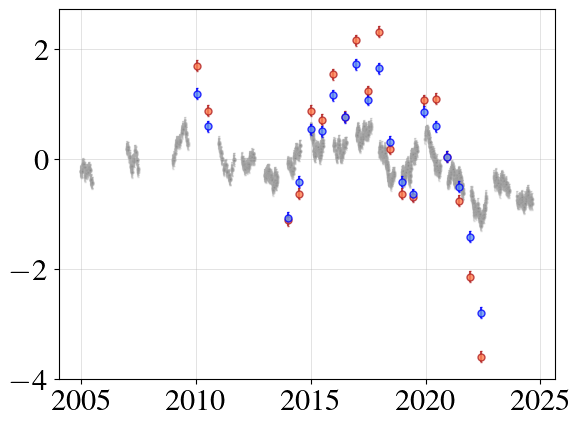

In [842]:
fig, ax = plt.subplots()

ax.errorbar(synth_opt_lc['time'].to_value('decimalyear'), synth_opt_lc['mag'], yerr=synth_opt_lc['mag_err'],
            ls='None', marker='o', ms=2,
            mfc='grey', mec='darkgrey', c='darkgrey', capsize=1,
            alpha=0.4, zorder=-1)

ax.errorbar(synth_w1['time'].to_value('decimalyear'), synth_w1['mag'], yerr=synth_w1['mag_err'],
            ls='None', marker='o', ms=5,
            mfc='coral', mec='firebrick', c='firebrick', capsize=1,
            alpha=0.8, label='Synth W1')

ax.errorbar(synth_w2['time'].to_value('decimalyear'), synth_w2['mag'], yerr=synth_w2['mag_err'],
            ls='None', marker='o', ms=5,
            mfc='cornflowerblue', mec='blue', c='blue', capsize=1,
            alpha=0.8, label='Synth W2')
# ax.legend()
ax.grid(lw=0.5, alpha=0.5)

In [829]:
fwm = FixedWidthModel(plateifu='8553-1901', optical_data=synth_opt_lc, verbose=True)

minimizer_args = dict(ranges=((-2, 2, 0.01),), weighted=1)
model1 = fwm.minimize_chisq(IR_data=synth_w1, **minimizer_args)
w1_results = np.array(fwm.results_log.copy())

model2 = fwm.minimize_chisq(IR_data=synth_w2, **minimizer_args)
w2_results = np.array(fwm.results_log.copy())

*** W1 & W2 data generated ***
lag: -2.000, amp: -1.591, const: -0.161, chi-square: 2786.683
lag: -1.990, amp: -1.580, const: -0.160, chi-square: 2788.250
lag: -1.980, amp: -1.533, const: -0.156, chi-square: 2797.323
lag: -1.970, amp: -1.524, const: -0.155, chi-square: 2799.613
lag: -1.960, amp: -1.516, const: -0.154, chi-square: 2800.745
lag: -1.950, amp: -1.521, const: -0.152, chi-square: 2801.015
lag: -1.940, amp: -1.540, const: -0.152, chi-square: 2798.208
lag: -1.930, amp: -1.559, const: -0.153, chi-square: 2794.959
lag: -1.920, amp: -1.572, const: -0.153, chi-square: 2793.364
lag: -1.910, amp: -1.574, const: -0.153, chi-square: 2793.767
lag: -1.900, amp: -1.568, const: -0.152, chi-square: 2793.881
lag: -1.890, amp: -1.571, const: -0.152, chi-square: 2793.854
lag: -1.880, amp: -1.560, const: -0.151, chi-square: 2795.483
lag: -1.870, amp: -1.551, const: -0.150, chi-square: 2797.721
lag: -1.860, amp: -1.574, const: -0.151, chi-square: 2793.915
lag: -1.850, amp: -1.564, const: -0.150

In [830]:
convw1, t_convw1, err_convw1 = fwm.convolve(model1[0], 0.5)
predw1, err_predw1, t_predw1, a1, c1, _ = fwm.predict_mags([model1[0]], IR_data=synth_w1)

convw2, t_convw2, err_convw2 = fwm.convolve(model2[0], 0.5)
predw2, err_predw2, t_predw2, a2, c2, _ = fwm.predict_mags([model2[0]], IR_data=synth_w2)

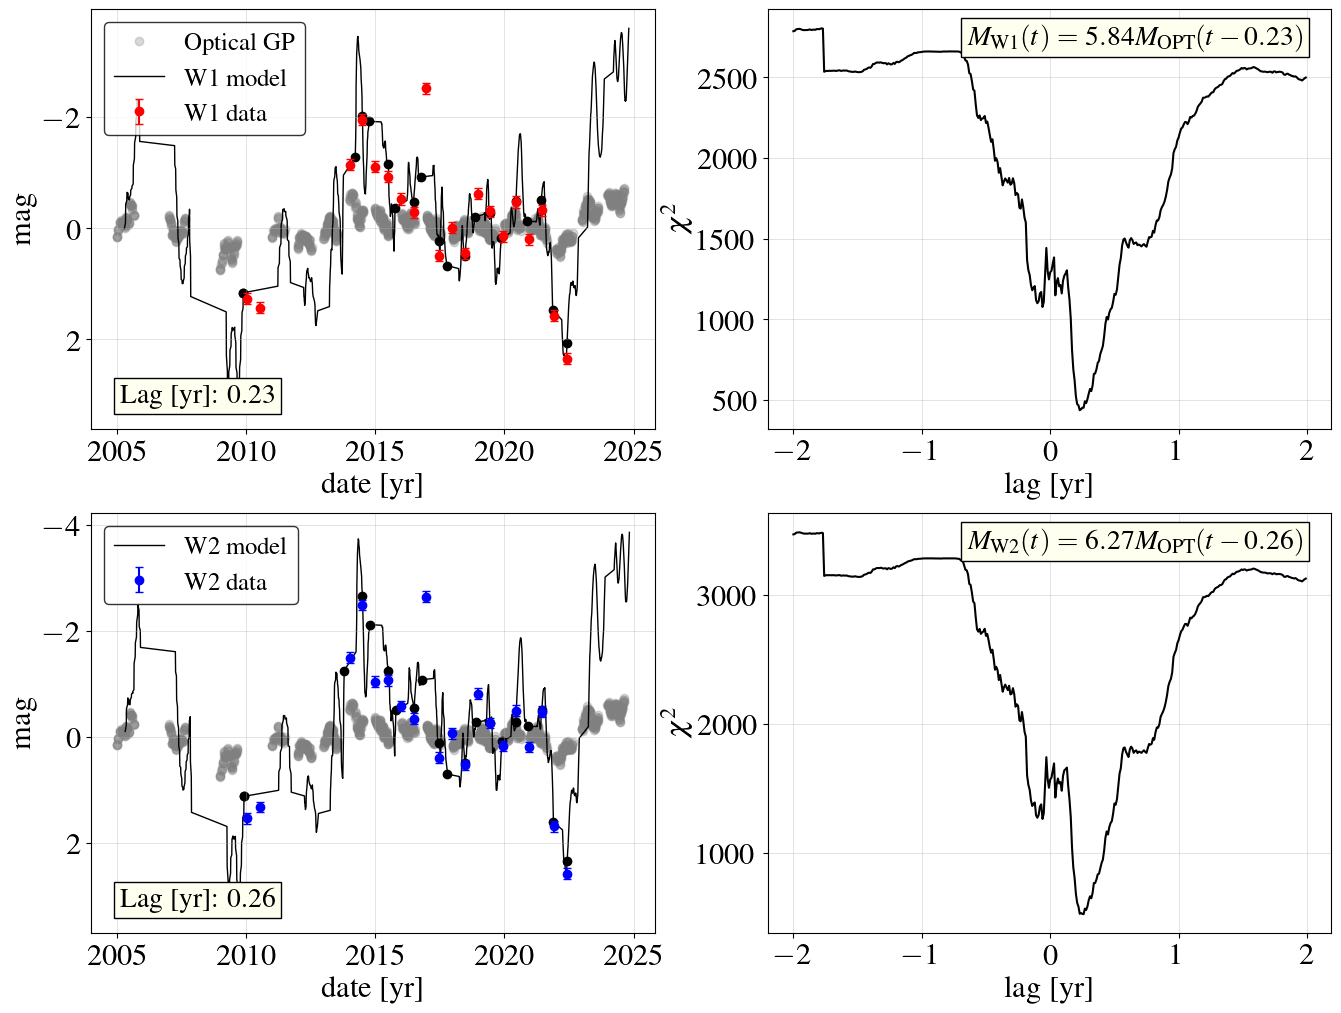

In [831]:
# Create a 2x2 grid of subplots with a large figure size (16x12 inches)
fig, ax = plt.subplots(figsize=(16,12), ncols=2, nrows=2)

# Top-left plot: Optical GP light curve and W1 model comparison
ax[0, 0].plot(
    fwm.optical_GP['time'].to_value('decimalyear'),  # Convert time to decimal years for x-axis
    fwm.optical_GP['mag'],                          # Magnitudes from optical Gaussian Process
    c='grey', lw=2, marker='o', ls='None', label='Optical GP',
    alpha=0.3, zorder=-1  # Grey dashed line for optical GP data
)

# Plot W1 model light curve: convolved and scaled model shifted by lag
ax[0, 0].plot(
    t_convw1 + model1[0],                           # Shift time by lag (model1[0])
    model1[1] * convw1 + model1[2],                 # Scale and offset convolved model flux
    c='k', lw=1, label='W1 model', zorder=-1       # Black line, behind other plots
)

# Scatter predicted W1 magnitudes on the same plot
ax[0, 0].scatter(t_predw1, predw1, c='k')

# Plot actual W1 data points with error bars (red circles)
ax[0, 0].errorbar(
    synth_w1['time'].to_value('decimalyear'),         # W1 observation times in decimal years
    synth_w1['mag'],                                  # W1 magnitudes
    yerr=synth_w1['mag_err'],                         # Errors on magnitudes
    c='red', capsize=3, linestyle='none', marker='o', label='W1 data'
)

# Add a text box showing the lag value in years on the bottom left
ax[0, 0].text(
    0.05, 0.05, 'Lag [yr]: ' + str(np.round(model1[0], 3)),  # Lag rounded to 3 decimals
    ha='left', va='bottom', fontsize=20,
    transform=ax[0, 0].transAxes,                          # Coordinates relative to axes
    bbox=dict(facecolor='ivory', edgecolor='k', alpha=1), # Ivory background with black border
    zorder=5                                              # Draw on top
)

# Invert y-axis so that magnitude decreases upward
ax[0, 0].invert_yaxis()

# Add legend with black edge and larger font
ax[0, 0].legend(edgecolor='k', fontsize=18)

# Label axes
ax[0, 0].set_ylabel('mag')
ax[0, 0].set_xlabel('date [yr]')

# Top-right plot: Chi-squared vs lag for W1 results
ax[0, 1].set_xlabel('lag [yr]')
ax[0, 1].set_ylabel(r'$\chi^2$')

# Plot chi-squared values from W1 fitting results
ax[0, 1].plot(w1_results[:, 0], w1_results[:, 3], c='k')

# Add text showing the W1 model equation and fitted parameters on top right
ax[0, 1].text(
    0.95, 0.9,
    r'$M_{\rm W1}(t)=' + str(np.round(model1[1], 2)) + r'M_{\rm OPT}(t-' + str(np.round(model1[0],3)) + ')$',
    ha='right', va='bottom', fontsize=20,
    transform=ax[0, 1].transAxes,
    bbox=dict(facecolor='ivory', edgecolor='k', alpha=1),
    zorder=5
)

# Bottom-left plot: Optical GP and W2 model comparison (similar to top-left)
ax[1, 0].plot(
    fwm.optical_GP['time'].to_value('decimalyear'),
    fwm.optical_GP['mag'],
    c='grey', lw=2, marker='o', ls='None',
    alpha=0.3, zorder=-1 
)
ax[1, 0].plot(
    t_convw2 + model2[0],
    model2[1] * convw2 + model2[2],
    c='k', lw=1, label='W2 model', zorder=-1
)
ax[1, 0].scatter(t_predw2, predw2, c='k')
ax[1, 0].errorbar(
    synth_w2['time'].to_value('decimalyear'),
    synth_w2['mag'],
    yerr=synth_w2['mag_err'],
    c='blue', capsize=3, linestyle='none', marker='o', label='W2 data'
)

# Add lag text box on bottom left
ax[1, 0].text(
    0.05, 0.05, 'Lag [yr]: ' + str(np.round(model2[0], 3)),
    ha='left', va='bottom', fontsize=20,
    transform=ax[1, 0].transAxes,
    bbox=dict(facecolor='ivory', edgecolor='k', alpha=1),
    zorder=5
)

# Invert y-axis for magnitudes
ax[1, 0].invert_yaxis()

# Legend and axis labels
ax[1, 0].legend(edgecolor='k', fontsize=18)
ax[1, 0].set_ylabel('mag')
ax[1, 0].set_xlabel('date [yr]')

# Bottom-right plot: Chi-squared vs lag for W2 results
ax[1, 1].set_ylabel(r'$\chi^2$')
ax[1, 1].set_xlabel('lag [yr]')
ax[1, 1].plot(w2_results[:, 0], w2_results[:, 3], c='k')

# Add W2 model equation text box
ax[1, 1].text(
    0.95, 0.9,
    r'$M_{\rm W2}(t)=' + str(np.round(model2[1], 2)) + r'M_{\rm OPT}(t-' + str(np.round(model2[0],3)) + ')$',
    ha='right', va='bottom', fontsize=20,
    transform=ax[1, 1].transAxes,
    bbox=dict(facecolor='ivory', edgecolor='k', alpha=1),
    zorder=5
)

# Add grid lines with light opacity and thin lines to all four subplots
for i in range(2):
    for j in range(2):
        ax[i, j].grid(lw=0.5, alpha=0.5)

# Make the x-axis of the top-left and bottom-left plots share the same scale
ax[0, 0].sharex(ax[1, 0])


In [752]:
from tqdm import tqdm
N=1000
best_fit_params, best_fit_lag_err = [], []
synth_lcs = []

lags=[0.25]*N#np.random.uniform(0.01, 2, size=N) # in years

for i in tqdm(range(N)):
    lag=(lags[i]*u.year).to(u.day).value

    synth_opt_lc_full, synth_w1_full, synth_w2_full = generate_sim_LC(lag=lag)
    synth_lcs.append(synth_opt_lc)

    synth_opt_lc = synth_opt_lc_full[combined_mask]

    w1_inds = np.argmin(np.abs(synth_w1_full['time'].to_value('decimalyear')[:, None]-wise_times[None, :]), axis=0)
    synth_w1 = synth_w1_full[w1_inds]
    synth_w1['mag'] *= np.random.uniform(1, 10)
    synth_w1['mag']+=np.random.normal(loc=0, scale=0.1, size=np.size(synth_w1['mag']))

    w2_inds = np.argmin(np.abs(synth_w2_full['time'].to_value('decimalyear')[:, None]-wise_times[None, :]), axis=0)
    synth_w2 = synth_w2_full[w2_inds]
    synth_w2['mag'] *= np.random.uniform(1, 10)
    synth_w2['mag']+=np.random.normal(loc=0, scale=0.1, size=np.size(synth_w2['mag']))
    
    fwm = FixedWidthModel(plateifu='8553-1901', optical_data=synth_opt_lc, verbose=0)

    minimizer_args = dict(ranges=((-2, 2, 0.01),), weighted=0)
    model1 = fwm.minimize_chisq(IR_data=synth_w1, **minimizer_args)
    w1_results = np.array(fwm.results_log.copy())
    best_fit_lag_err.append(model1[0]-lags[i])
    best_fit_params.append(model1)
    convw1, t_convw1, err_convw1 = fwm.convolve(model1[0], 0.5)
    predw1, err_predw1, t_predw1, a1, c1, _ = fwm.predict_mags([model1[0]], IR_data=synth_w1)

100%|██████████| 1000/1000 [03:02<00:00,  5.48it/s]


In [753]:
best_fit_lags = np.array(best_fit_params)[:,0]

median = np.median(best_fit_lag_err)
lower = np.percentile(best_fit_lag_err, 16)
upper = np.percentile(best_fit_lag_err, 84)

In [ ]:
# lags, best_fit_lag_err

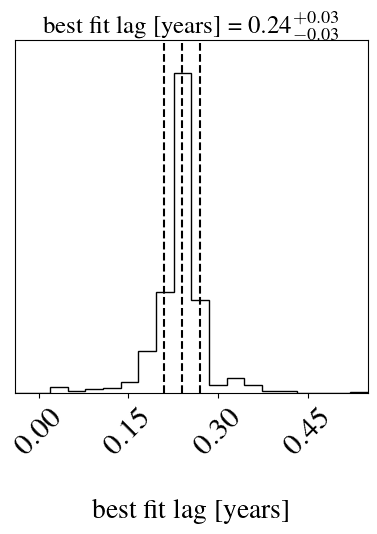

In [754]:
import corner

fig = plt.figure(figsize=(6, 6)) 
fig = corner.corner(np.array(best_fit_lags).reshape(-1, 1),
            fig=fig,
            labels=["best fit lag [years]"],
            show_titles=True,
            title_fmt=".2f",
            quantiles=[0.16, 0.5, 0.84],
            title_kwargs={"fontsize": 18},
            label_kwargs={"fontsize": 20},
            color="k")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

start_year = 2005#synth_opt_lc['time'][0].to_value('decimalyear')
end_year = 2025#synth_opt_lc['time'][-1].to_value('decimalyear')
total_days = (end_year - start_year) * 365
times = np.arange(total_days)  

def simulate_crts(times, base_year=start_year):
    mask = np.zeros_like(times, dtype=bool)
    for year in range(2005, 2014):
        start = (year - base_year) * 365                        #for each year,
        season_length = np.random.choice([180, 240])            #6-8 month seasonal observing period,
        for day in np.arange(start, start + season_length, 
                             np.random.randint(14, 30)):        #revisit the same field every 2-4 weeks,
            for offset in range(4):                             #4 observations per visit
                mask[start + int(day)+offset] = True            
    return mask

def simulate_asassn(times, base_year=start_year):
    mask = np.zeros_like(times, dtype=bool)
    for year in range(2012, 2020):
        start = (year - base_year) * 365
        for day in range(start, start + 200):
            if np.random.rand() < 0.3:  # 70% nightly observing efficiency
                mask[day] = True
    return mask

def simulate_ztf(times, base_year=start_year):
    mask = np.zeros_like(times, dtype=bool)
    for year in range(2018, 2025):
        start = (year - base_year) * 365
        for day in np.arange(start, start + 240, 3):  # every 3 nights
            mask[int(day)] = True
    return mask


In [ ]:
mask_crts = simulate_crts(times)
mask_asassn = simulate_asassn(times)
mask_ztf = simulate_ztf(times)

combined_mask = mask_crts | mask_asassn | mask_ztf
observed_times = times[combined_mask]


In [ ]:
lag=(0.1*u.year).to(u.day).value
print(lag)
synth_opt_lc_full, synth_w1_full, synth_w2_full = generate_sim_LC(lag=lag)

synth_opt_lc = synth_opt_lc_full[combined_mask]
w1_inds = np.argmin(np.abs(synth_w1_full['time'].to_value('decimalyear')[:, None]-wise_times[None, :]), axis=0)
synth_w1 = synth_w1_full[w1_inds]
synth_w1['mag']+=np.random.normal(loc=0, scale=0.1, size=np.size(synth_w1['mag']))
w2_inds = np.argmin(np.abs(synth_w2_full['time'].to_value('decimalyear')[:, None]-wise_times[None, :]), axis=0)
synth_w2 = synth_w2_full[w2_inds]
synth_w2['mag']+=np.random.normal(loc=0, scale=0.1, size=np.size(synth_w2['mag']))

36.525


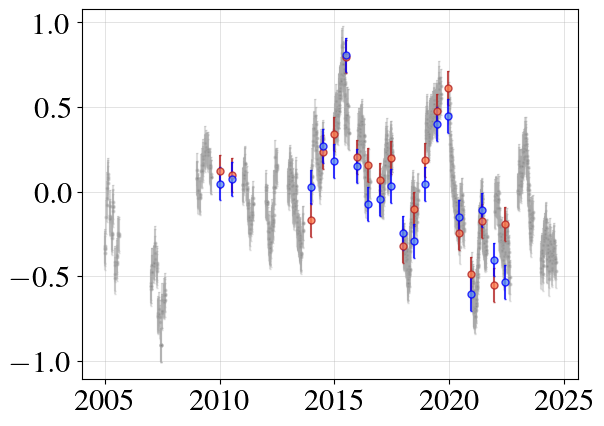

In [ ]:
fig, ax = plt.subplots()

ax.errorbar(synth_opt_lc['time'].to_value('decimalyear'), synth_opt_lc['mag'], yerr=synth_opt_lc['mag_err'],
            ls='None', marker='o', ms=2,
            mfc='grey', mec='darkgrey', c='darkgrey', capsize=1,
            alpha=0.4, zorder=-1)

ax.errorbar(synth_w1['time'].to_value('decimalyear'), synth_w1['mag'], yerr=synth_w1['mag_err'],
            ls='None', marker='o', ms=5,
            mfc='coral', mec='firebrick', c='firebrick', capsize=1,
            alpha=0.8, label='Synth W1')

ax.errorbar(synth_w2['time'].to_value('decimalyear'), synth_w2['mag'], yerr=synth_w2['mag_err'],
            ls='None', marker='o', ms=5,
            mfc='cornflowerblue', mec='blue', c='blue', capsize=1,
            alpha=0.8, label='Synth W2')
# ax.legend()
ax.grid(lw=0.5, alpha=0.5)